In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Dec  7 18:45:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install --upgrade transformers


Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (4.0.0)


In [ ]:
pip install simpletransformers

In [ ]:
%cd /content/drive/Shared drives/CS594 DNLP Project/

/content/drive/Shared drives/CS594 DNLP Project


In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# from datasets import load_metric

# metric = load_metric("bertscore")

In [ ]:
!pip install py-rouge

In [ ]:
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs

In [ ]:
import rouge

In [ ]:
# !pip install -U git+https://github.com/davebulaval/bert_score.git@master

!pip install bert_score


In [ ]:
# pip install datasets

In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
from bert_score import score

### Loading Data 

In [ ]:
data_path = r'/content/drive/Shared drives/CS594 DNLP Project/Data/Data 2_2'

In [ ]:
train_df = pd.read_csv(os.path.join(data_path, '2_2 Training data.csv'), usecols= [1,2], names = ['input_text', 'target_text'], header  = 0).dropna()
train_df.head()

,input_text,target_text
0,the july deadline to begin withdrawing troops ...,lindsey withdrawl should only begin when condi...
1,libyan military aircraft crashed wednesday sou...,pilot and eject before the newspaper reports
2,south korea beat fellow world cup finalists iv...,south korea beat ivory coast in friendly inter...
3,sensing an imminent the government recognized ...,ouattara forces say they control
4,top official has criticized claim that the six...,official denies iran claim that six of its lea...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9995 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_text   9995 non-null   object
 1   target_text  9995 non-null   object
dtypes: object(2)
memory usage: 234.3+ KB


In [ ]:
val_df = pd.read_csv(os.path.join(data_path, '2_2 Validation data.csv'), usecols= [1,2], names = ['input_text', 'target_text'], header  = 0).dropna()
val_df.head()

,input_text,target_text
0,los angeles galaxy midfielder david beckham ha...,david beckham has revealed he is set to miss t...
1,los angeles clippers owner donald sterling is ...,legality of sterling recording depends on stat...
2,an ohio man pleaded guilty thursday and was se...,matthew hoffman enters guilty pleas in novembe...
3,been rough week for alec not only did he give ...,alec baldwin yelled slur at photographer
4,maritime task force was scouring the stormy wa...,ship sinks about miles off the coast of tripoli


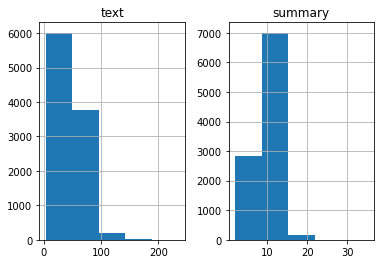

In [ ]:
text_count = []
summary_count = []

for t in train_df['input_text']:
    text_count.append(len(t.split()))
for t in train_df['target_text']:
    summary_count.append(len(t.split()))

graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Check how much % of text have 0-925 words
cnt=0
for i in train_df['input_text']:
    if(len(i.split())<=80):
        cnt=cnt+1
print(cnt/len(train_df['input_text']))

0.9456728364182091


In [ ]:
#Check how much % of summary have 0-50 words
cnt=0
for i in train_df['target_text']:
    if(0 <= len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(train_df['target_text']))

0.9829914957478739


In [ ]:
max_seq_length = 80
max_length = 15

### Building Transformers models

In [ ]:
def model_transformers(epochs, train_batch_size,eval_batch_size,max_seq_length,max_length,repetition_penalty):
  model_args = Seq2SeqArgs()
  model_args.num_train_epochs = epochs
  model_args.no_save = True
  model_args.evaluate_generated_text = True
  model_args.evaluate_during_training = False
  model_args.evaluate_during_training_verbose = False
  model_args.overwrite_output_dir = True
  model_args.train_batch_size = train_batch_size
  model_args.eval_batch_size = eval_batch_size
  model_args.max_seq_length = max_seq_length
  model_args.max_length = max_length
  model_args.early_stopping = False
  model_args.do_sample = True
  model_args.repetition_penalty = repetition_penalty


  model = Seq2SeqModel(
  encoder_decoder_type='bart',
  encoder_decoder_name='facebook/bart-large-cnn',
  args=model_args,
  use_cuda=True,
  )
  return model

## Evaluation Metric

### The following code is adapted from https://pypi.org/project/py-rouge/

In [ ]:
def rouge_eval(x,y):
  evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                          max_n=2,
                          limit_length=True,
                          length_limit=100,
                          length_limit_type='words',
                          apply_avg=True,
                          # apply_best=apply_best,
                          alpha=0.5, # Default F1_score
                          weight_factor=1.2,
                          stemming=True)
  scores  = evaluator.get_scores(x,y)
  return [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], scores['rouge-w']['f']]


In [ ]:
def rouge_eval2(x,y):
  evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                          max_n=2,
                          limit_length=True,
                          length_limit=100,
                          length_limit_type='words',
                          apply_avg=True,
                          # apply_best=apply_best,
                          alpha=0.5, # Default F1_score
                          weight_factor=1.2,
                          stemming=True)
  scores  = evaluator.get_scores(x,y)
  return np.sum([scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], scores['rouge-w']['f']])


In [ ]:
def bert_score(x,y):
  # print(x)
  # print(y)
  F1 = score(y,x, lang="en", verbose=False)[2]
  return F1

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
x = torch.tensor([3,5])
print(x.numpy().mean())
x

4.0


tensor([3, 5])

## Training and Hyperparameter tuning with the validation dataset

In [ ]:
def objective_func_TRA(args):

  repetition_penalty = args['repetition_penalty']

  par_dict = {'repetition_penalty': repetition_penalty}
  print(par_dict)

  model = model_transformers(10, 32,16,max_seq_length,max_length,repetition_penalty)
  model.train_model(train_df)
  eval_score = (model.eval_model(val_df, output_dir=None, verbose=False, silent=True, bertscore = bert_score)['bertscore']).numpy().mean()
  print(eval_score)

  return -(eval_score)

space = {'repetition_penalty': hp.uniform('repetition_penalty',1, 4)
        }                  
                                                                 
best_TRA = fmin(objective_func_TRA, space, algo=tpe.suggest, max_evals=4)
print(best_TRA)

{'repetition_penalty': 1.9936376697246616}
  0%|          | 0/4 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb390ba9e8>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shutdown_workers()
Exception ignored in: 
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers

<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb390ba9e8>>
Traceback (most recent call last):

w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join

self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_

0.8532573
{'repetition_penalty': 1.1121876273942704}
 25%|██▌       | 1/4 [18:05<54:16, 1085.52s/it, best loss: -0.8532572984695435]

0.8545946
{'repetition_penalty': 3.048676772021243}
 50%|█████     | 2/4 [36:31<36:23, 1091.74s/it, best loss: -0.8545945882797241]

Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb32289710>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers

w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join

assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError
Exception ignored in: 
: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb32289710>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

can only join a child process
self._shu

Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb397b0f60>>
Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers

w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join

Exception ignored in: 
assert self._parent_pid == os.getpid(), 'can only join a child process'
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb397b0f60>>
Traceback (most recent call last):

AssertionError
: 
can only join a child process
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__

self._shu

0.85429543
{'repetition_penalty': 1.800569020947174}
 75%|███████▌  | 3/4 [54:14<18:03, 1083.01s/it, best loss: -0.8545945882797241]

0.8533296
100%|██████████| 4/4 [1:12:57<00:00, 1094.36s/it, best loss: -0.8545945882797241]
{'repetition_penalty': 1.1121876273942704}


In [ ]:
# def objective_func_TRA(args):

#   max_seq_length = args['max_seq_length']
#   max_length = args['max_length']
#   repetition_penalty = args['repetition_penalty']

#   par_dict = {'max_length': max_length, 'max_seq_length': max_seq_length, 'repetition_penalty': repetition_penalty}
#   print(par_dict)

#   model = model_transformers(10, 32,16,max_seq_length,max_length,repetition_penalty)
#   model.train_model(train_df)
#   eval_score = (model.eval_model(val_df, output_dir=None, verbose=False, silent=True, bertscore = bert_score)['bertscore']).numpy().mean()
#   print(eval_score)

#   return -(eval_score)

# space = {'max_length': hp.choice('max_length',[10,20,30]),  
#          'max_seq_length': hp.choice('max_seq_length',[20,40, 60, 80]),
#          'repetition_penalty': hp.uniform('repetition_penalty',1, 4)
#         }                  
                                                                 
# best_TRA = fmin(objective_func_TRA, space, algo=tpe.suggest, max_evals=10)
# print(best_TRA)

In [ ]:
{'repetition_penalty': 1.112}
best_bert= 0.8545945882797241

In [ ]:
print(dadafd)

NameError: ignored

In [ ]:
repetition_penalty = 1.112
par_dict = {'max_length': max_length, 'max_seq_length': max_seq_length, 'repetition_penalty': repetition_penalty}
print(par_dict)

model = model_transformers(10, 32,16,max_seq_length,max_length,repetition_penalty)
model.train_model(train_df)
# eval_score = model.eval_model(val_df, output_dir=None, verbose=False, silent=True, bertscore = bert_score)['bertscore']
# print(eval_score)

{'max_length': 15, 'max_seq_length': 80, 'repetition_penalty': 1.112}


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb3ca775f8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionErrorException ignored in: : can only join a child process<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fbb3ca775f8>>

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Excepti

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


(3130, 1.1029460926311085)

In [ ]:
y_pred  = model.predict(val_df['input_text'])

In [ ]:
y_pred[0]

'david beckham will miss the entire of the london globes'

In [ ]:
score(y_pred, list(val_df['target_text']), lang="en", verbose=True)[2].numpy().mean()

calculating scores...
computing bert embedding.



computing greedy matching.



done in 2.86 seconds, 349.68 sentences/sec


0.85041004

In [ ]:
# y_pred[:1]

In [ ]:
# list(val_df['target_text'])[:1]

['david beckham has revealed he is set to miss the entire mls season']

In [ ]:
# rouge_eval(y_pred[:2],list(val_df['target_text'])[:2])

[0.2590579710144928,
 0.14285714285714288,
 0.3131363822519541,
 0.1735242373326339]

In [ ]:
rouge_eval(y_pred,list(val_df['target_text']))

[0.19762373816842294,
 0.06694247895885913,
 0.2244183224621767,
 0.13175653912371083]

In [ ]:
pred_path = r'/content/drive/Shared drives/CS594 DNLP Project/Predictions/2/Validation'

In [ ]:
def pred_save(filename, y_pred):
  pred_df = pd.DataFrame()
  pred_df['Actual Summary'] = val_df['target_text']
  pred_df['Predicted Summary'] = y_pred
  pred_df.to_csv(os.path.join(pred_path,filename))

In [ ]:
pred_save('predicitions 22222 bertscore repp 1.112 .csv', y_pred)